In [1]:
import pandas as pd
import numpy as np
import json
import pprint
import matplotlib.pyplot as plt
import copy

def haversine_np(lon1, lat1, lon2, lat2, scaler=1.4):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    
    All args must be of equal length.    
    
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6378.137 * c
    return np.round(km * 1000 * scaler, decimals=0).astype('int')




def gen_problem_instance(raw_order_data_file, K=100, rnd_seed=1, sampling_time_span_seconds=3600, buffer_min=20, file_prefix='TEST', instance_name='1', **other_options):

    # raw_order_data_file = './opt_challenge_test_data_order.csv'
    # FILE_PREFIX = 'TEST'
    # K = 100
    # rnd_seed = 1

    raw_order_df = pd.read_csv(raw_order_data_file, parse_dates=['ord_date'])


    if rnd_seed > 0:
        np.random.seed(rnd_seed)

    earliest_date = raw_order_df.ord_date.min()

    raw_order_df['ord_time_sec'] = (raw_order_df.ord_date - earliest_date).dt.total_seconds().astype('int')
    raw_order_df['cook_time_sec'] = (raw_order_df.cook_time * 60).astype('int')
    raw_order_df['capacity_bike'] = (raw_order_df.capacity_bike * 100).astype('int')



    while True:
        sampling_start_time = np.random.randint(0, raw_order_df['ord_time_sec'].max() - sampling_time_span_seconds)
        sampling_end_time = sampling_start_time + sampling_time_span_seconds

        sampling_raw_order_df = raw_order_df[(raw_order_df['ord_time_sec'] >= sampling_start_time) & (raw_order_df['ord_time_sec'] <= sampling_end_time)]

        if len(sampling_raw_order_df) >= K * 1.2: # We should have enough sampling orders to choose from
            break

    sampling_raw_order_df = sampling_raw_order_df.assign(ord_time_sec = sampling_raw_order_df.ord_time_sec - sampling_raw_order_df.ord_time_sec.min())


    BUFFER_TIME_SEC = buffer_min * 60   # deadline = earliest delivery time + buffer time

    BIKE_SERVICE_TIME_SEC = other_options.get('BIKE_SERVICE_TIME_SEC', 120)     # 2 minutes (bikes)
    WALK_SERVICE_TIME_SEC = other_options.get('WALK_SERVICE_TIME_SEC', 120)     # 2 minutes (walks)
    CAR_SERVICE_TIME_SEC = other_options.get('CAR_SERVICE_TIME_SEC', 180)      # 3 minutes (cars)

    BIKE_SPEED = 1000 / (3.15 * 60) # 3.15 minute / km
    WALK_SPEED = BIKE_SPEED * 0.25 # 25% of bikes
    CAR_SPEED = BIKE_SPEED * 0.8 # 80% of bikes

    BIKE_CAPA = other_options.get('BIKE_CAPA', 100) # ~ 3 orders
    WALK_CAPA = other_options.get('WALK_CAPA', 70)  # ~ 2 orders
    CAR_CAPA = other_options.get('CAR_CAPA', 200)  # ~ 5 orders

    BIKE_VAR_COST = other_options.get('BIKE_VAR_COST', 60)  # per 100 m travel
    WALK_VAR_COST = other_options.get('WALK_VAR_COST', 30)  # per 100 m travel
    CAR_VAR_COST = other_options.get('CAR_VAR_COST', 100)   # per 100 m travel


    BIKE_FIXED_COST = other_options.get('BIKE_FIXED_COST', 5000) # fixed cost
    WALK_FIXED_COST = other_options.get('WALK_FIXED_COST', 5000)  # fixed cost
    CAR_FIXED_COST = other_options.get('CAR_FIXED_COST', 5000)   # fixed cost


    NUM_BIKES = int(K * other_options.get('NUM_BIKES_RATIO', 0.2))    # availability
    NUM_WALKS = int(K * other_options.get('NUM_WALKS_RATIO', 0.3))    # availability
    NUM_CARS = int(K * other_options.get('NUM_CARS_RATIO', 1))       # availability (practically unlimited)



    sample_orders_df = sampling_raw_order_df.sample(K, replace=False).sort_values(by='ord_date')


    shop_lats = list(sample_orders_df.shop_lat)
    shop_lons = list(sample_orders_df.shop_lon)
    dlv_lats = list(sample_orders_df.dlv_lat)
    dlv_lons = list(sample_orders_df.dlv_lon)

    all_lats = shop_lats + dlv_lats
    all_lons = shop_lons + dlv_lons

    DIST = [
        haversine_np(np.array([lon]), np.array([lat]), np.array(all_lons), np.array(all_lats)).tolist()
        for lat, lon in zip(all_lats, all_lons)
    ]


    # DLV_DEADLINE is defined as the earlist delivery time + BUFFER_TIME_SEC by the always-available vehicles (cars)
    ORDERS = [
        # ORD_ID, ORD_TIME, SHOP_LAT, SHOP_LON, DLV_LAT, DLV_LON, VOL, COOK_TIME, DLV_DEADLINE
        [k, row[1].ord_time_sec, row[1].shop_lat, row[1].shop_lon, row[1].dlv_lat, row[1].dlv_lon, row[1].cook_time_sec, row[1].capacity_bike, int(round(row[1].ord_time_sec + row[1].cook_time_sec + CAR_SERVICE_TIME_SEC + BUFFER_TIME_SEC + DIST[k][k+K]/CAR_SPEED))]
        for k,row in enumerate(sample_orders_df.iterrows())
    ]

    # INC_BUFFER_TIME_PROB > 0 이면 INC_BUFFER_TIME_PROB 확률로 order의 deadline을 INC_BUFFER_TIME(초) 만큼 증가시킴
    inc_buffer_time_prob = other_options.get('INC_BUFFER_TIME_PROB', 0)
    if inc_buffer_time_prob > 0:
        inc_buffer_time = other_options.get('INC_BUFFER_TIME', 10) * 60
        for o in ORDERS:
            if np.random.rand() <= inc_buffer_time_prob:
                o[-1] += inc_buffer_time





    prob_filename = f'{file_prefix}_{instance_name}'

    prob = {
        'name': prob_filename,
        'K': K,
        # 'S': rnd_seed,
        # 'BUFFER_TIME_SEC': BUFFER_TIME_SEC,

        'RIDERS': [
            # name, speed, capa, var_cost, fixed_cost, service_time, available number
            ['BIKE', BIKE_SPEED, BIKE_CAPA, BIKE_VAR_COST, BIKE_FIXED_COST, BIKE_SERVICE_TIME_SEC, NUM_BIKES],
            ['WALK', WALK_SPEED, WALK_CAPA, WALK_VAR_COST, WALK_FIXED_COST, WALK_SERVICE_TIME_SEC, NUM_WALKS],
            ['CAR', CAR_SPEED, CAR_CAPA, CAR_VAR_COST, CAR_FIXED_COST, CAR_SERVICE_TIME_SEC, NUM_CARS]
        ],

        'ORDERS': ORDERS,

        'DIST': DIST
    }


    if other_options.get('SAVE_TO_FILE', True):
        save_prob(prob, file_prefix, instance_name)
        # # Write to a file
        # with open(prob_filename + '.json', 'w') as f:
        #     pretty_json_str = pprint.pformat(prob, compact=True, sort_dicts=False).replace("'",'"')
        #     f.write(pretty_json_str)


    return prob


def save_prob(prob, file_prefix, instance_name):
    prob_filename = f'{file_prefix}_{instance_name}'

    prob['name'] = prob_filename

    # Write to a file
    with open(prob_filename + '.json', 'w') as f:
        pretty_json_str = pprint.pformat(prob, compact=True, sort_dicts=False).replace("'",'"')
        f.write(pretty_json_str)



# 주어진 문제 list의 문제들의 합침. 이 때 모든 ORDERS를 합쳐 첫번째 문제의 ORDERS을 replace함
def merge_problems(list_of_problems, translations=None, rotations=None):
    list_of_orderlists = []
    for p in list_of_problems:
        list_of_orderlists.append(p['ORDERS'])

    merged_orders = merge_orders(list_of_orderlists, translations, rotations)

    shop_lats = [o[2] for o in merged_orders]
    shop_lons = [o[3] for o in merged_orders]
    dlv_lats = [o[4] for o in merged_orders]
    dlv_lons = [o[5] for o in merged_orders]

    all_lats = shop_lats + dlv_lats
    all_lons = shop_lons + dlv_lons

    MERGED_DIST = [
        haversine_np(np.array([lon]), np.array([lat]), np.array(all_lons), np.array(all_lats)).tolist()
        for lat, lon in zip(all_lats, all_lons)
    ]

    p1 = list_of_problems[0]

    merged_riders = copy.deepcopy(p1['RIDERS'])
    for idx, r in enumerate(merged_riders):
        r[-1] = sum([p['RIDERS'][idx][-1] for p in list_of_problems])

    merged_prob = {
        'name': p1['name'],
        'K': len(merged_orders),
        'RIDERS': merged_riders,
        'ORDERS': merged_orders,
        'DIST': MERGED_DIST
    }

    return merged_prob


def merge_orders(list_of_orderlists, translations=None, rotations=None):


    if translations == None:
        translations = [(0,0)] * len(list_of_orderlists)

    if rotations == None:
        rotations = [0] * len(list_of_orderlists)

    merged_orders = []
    for orders, (tran_x, tran_y), r in zip(list_of_orderlists, translations, rotations):
        order_copy = orders.copy()
        for o in order_copy:
            o[2] += tran_x
            o[3] += tran_y
            o[4] += tran_x
            o[5] += tran_y

        center_x = np.mean([o[2] for o in order_copy])
        center_y = np.mean([o[3] for o in order_copy])

        for o in order_copy:
            qx, qy = rotate((o[2], o[3]), (center_x, center_y), r)
            o[2], o[3] = qx, qy
            qx, qy = rotate((o[4], o[5]), (center_x, center_y), r)
            o[4], o[5] = qx, qy

        
        merged_orders.extend(order_copy)
    merged_orders = sorted(merged_orders, key=lambda x:x[1])
    for idx,o in enumerate(merged_orders):
        o[0] = idx

    return merged_orders


def rotate(point, origin, degrees):
    radians = np.deg2rad(degrees)
    x,y = point
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = np.cos(radians)
    sin_rad = np.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
    return qx, qy

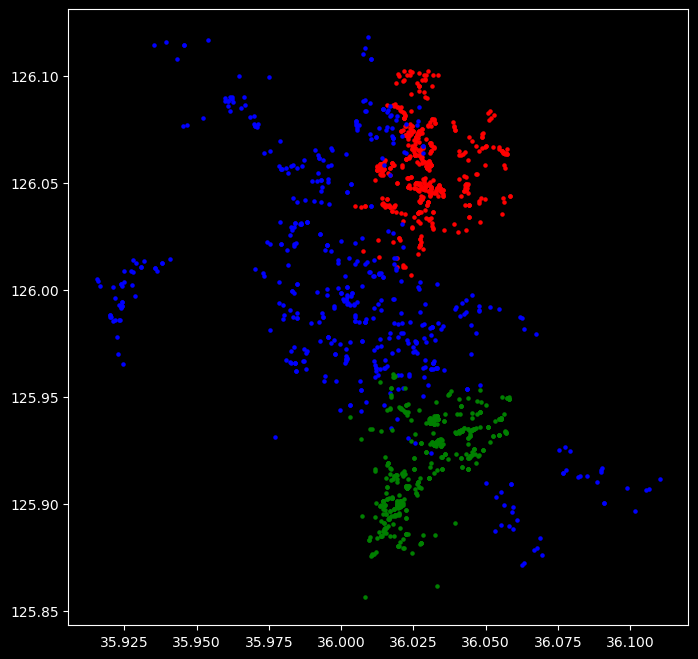

In [3]:

p1 = gen_problem_instance('./opt_challenge_data_order_density_high.csv', 
                     K=500, 
                     rnd_seed=2, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='1', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = False
                     )

p2 = gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=500, 
                     rnd_seed=15, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='6', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=9000, 
                     WALK_FIXED_COST=3000, 
                     CAR_FIXED_COST=5000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

p3 = gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=500, 
                     rnd_seed=2, 
                     buffer_min=40, 
                     file_prefix='STAGE2', 
                     instance_name='4', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=8000, 
                     WALK_FIXED_COST=5000, 
                     CAR_FIXED_COST=6000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

orders1 = p1['ORDERS']
orders2 = p2['ORDERS']
orders3 = p3['ORDERS']


plt.subplots(figsize=(8, 8))
node_size = 5

shop_x1 = [o[2]+0.03 for o in orders1]
shop_y1 = [o[3]+0.06 for o in orders1]

center_x1 = np.mean([o[2] for o in orders1])
center_y1 = np.mean([o[3] for o in orders1])

plt.scatter(shop_x1, shop_y1, c='red', s=node_size, label='SHOPS')


center_x2 = np.mean([o[2] for o in orders2])
center_y2 = np.mean([o[3] for o in orders2])

r = 150

for o in orders2:
    qx, qy = rotate((o[2], o[3]), (center_x2, center_y2), r)
    o[2], o[3] = qx, qy
    qx, qy = rotate((o[4], o[5]), (center_x2, center_y2), r)
    o[4], o[5] = qx, qy

shop_x2 = [o[2] for o in orders2]
shop_y2 = [o[3] for o in orders2]

plt.scatter(shop_x2, shop_y2, c='blue', s=node_size, label='SHOPS')

center_x3 = np.mean([o[2] for o in orders3])
center_y3 = np.mean([o[3] for o in orders3])

r = 40

for o in orders3:
    qx, qy = rotate((o[2], o[3]), (center_x3, center_y3), r)
    o[2], o[3] = qx, qy
    qx, qy = rotate((o[4], o[5]), (center_x3, center_y3), r)
    o[4], o[5] = qx, qy


shop_x3 = [o[2]+0.03 for o in orders3]
shop_y3 = [o[3]-0.08 for o in orders3]

plt.scatter(shop_x3, shop_y3, c='green', s=node_size, label='SHOPS')



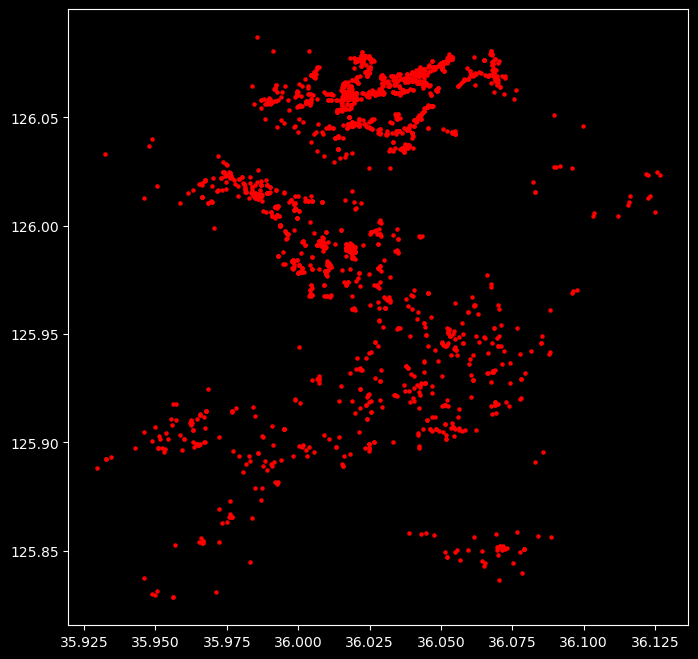

In [4]:

p1 = gen_problem_instance('./opt_challenge_data_order_density_high.csv', 
                     K=1000, 
                     rnd_seed=22, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='1', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = False
                     )

p2 = gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=500, 
                     rnd_seed=152, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='6', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=9000, 
                     WALK_FIXED_COST=3000, 
                     CAR_FIXED_COST=5000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

p3 = gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=500, 
                     rnd_seed=22, 
                     buffer_min=40, 
                     file_prefix='STAGE2', 
                     instance_name='4', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=8000, 
                     WALK_FIXED_COST=5000, 
                     CAR_FIXED_COST=6000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

orders1 = p1['ORDERS']
orders2 = p2['ORDERS']
orders3 = p3['ORDERS']

merged_orders = merge_orders([orders1, orders2, orders3], translations=[(0.03,0.06), (0.03,-0.08), (0,0)], rotations=[80, 40, 150])


plt.subplots(figsize=(8, 8))
node_size = 5

shop_x1 = [o[2] for o in merged_orders]
shop_y1 = [o[3] for o in merged_orders]

center_x1 = np.mean([o[2] for o in merged_orders])
center_y1 = np.mean([o[3] for o in merged_orders])

plt.scatter(shop_x1, shop_y1, c='red', s=node_size, label='SHOPS')


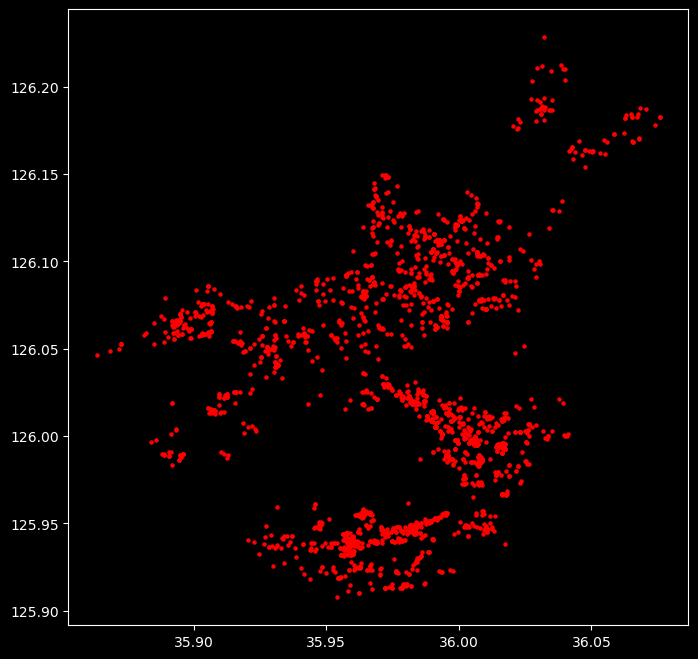

In [28]:

p1 = gen_problem_instance('./opt_challenge_data_order_density_high.csv', 
                     K=500, 
                     rnd_seed=23, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='1', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = False
                     )

p2 = gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=1000, 
                     rnd_seed=153, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='6', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=9000, 
                     WALK_FIXED_COST=3000, 
                     CAR_FIXED_COST=5000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

p3 = gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=500, 
                     rnd_seed=23, 
                     buffer_min=40, 
                     file_prefix='STAGE2', 
                     instance_name='4', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=8000, 
                     WALK_FIXED_COST=5000, 
                     CAR_FIXED_COST=6000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

orders1 = p1['ORDERS']
orders2 = p2['ORDERS']
orders3 = p3['ORDERS']

merged_orders = merge_orders([orders1, orders2, orders3], translations=[(-0.03,-0.06), (-0.03,0.08), (0,0)], rotations=[80, 40, 150])


plt.subplots(figsize=(8, 8))
node_size = 5

shop_x1 = [o[2] for o in merged_orders]
shop_y1 = [o[3] for o in merged_orders]

center_x1 = np.mean([o[2] for o in merged_orders])
center_y1 = np.mean([o[3] for o in merged_orders])

plt.scatter(shop_x1, shop_y1, c='red', s=node_size, label='SHOPS')


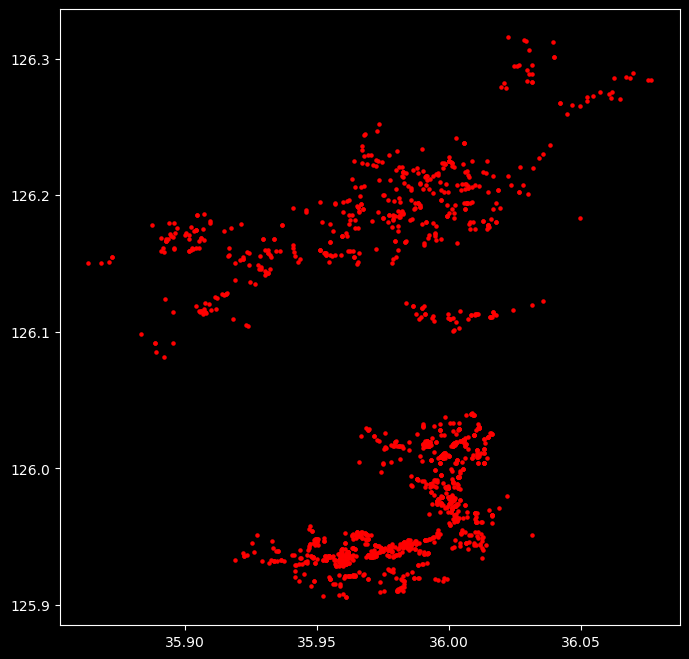

In [25]:

p1 = gen_problem_instance('./opt_challenge_data_order_density_high.csv', 
                     K=500, 
                     rnd_seed=2, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='1', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = False
                     )

p2 = gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=500, 
                     rnd_seed=15, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='6', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=9000, 
                     WALK_FIXED_COST=3000, 
                     CAR_FIXED_COST=5000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

p3 = gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=500, 
                     rnd_seed=2, 
                     buffer_min=40, 
                     file_prefix='STAGE2', 
                     instance_name='4', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=8000, 
                     WALK_FIXED_COST=5000, 
                     CAR_FIXED_COST=6000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

orders1 = p1['ORDERS']
orders2 = p2['ORDERS']
orders3 = p3['ORDERS']

merged_orders = merge_orders([orders1, orders2, orders3], translations=[(-0.03,-0.06), (-0.03,0.18), (0,0)], rotations=[80, 40, 10])


plt.subplots(figsize=(8, 8))
node_size = 5

shop_x1 = [o[2] for o in merged_orders]
shop_y1 = [o[3] for o in merged_orders]

center_x1 = np.mean([o[2] for o in merged_orders])
center_y1 = np.mean([o[3] for o in merged_orders])

plt.scatter(shop_x1, shop_y1, c='red', s=node_size, label='SHOPS')


# Generate test instances


We generate the instances by giving
- A raw order history file provided from 우아한형제
- K: number of orders to randomly select
- rnd_seed: random seed number
- file_prefix: prefix string to be added to the filenames
- instance_name: will be added to the filenames as a posefix
- **other_options


## Public instances for training

In [17]:

p = gen_problem_instance('./opt_challenge_data_order_density_high.csv', 
                     K=2000, 
                     rnd_seed=33, 
                     buffer_min=25, 
                     file_prefix='STAGE3', 
                     instance_name='1', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=6000, 
                     WALK_FIXED_COST=3000, 
                     CAR_FIXED_COST=5000,
                     NUM_BIKES_RATIO=0.3,
                     NUM_WALKS_RATIO=0.1,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=5,
                     SAVE_TO_FILE = True
                     )



p = gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=2000, 
                     rnd_seed=41, 
                     buffer_min=30, 
                     file_prefix='STAGE3', 
                     instance_name='2', 
                     sampling_time_span_seconds=3600*8,
                     BIKE_FIXED_COST=8000, 
                     WALK_FIXED_COST=5000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.4,
                     NUM_WALKS_RATIO=0.2,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = True
                     )



p = gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=2000, 
                     rnd_seed=55, 
                     buffer_min=25, 
                     file_prefix='STAGE3', 
                     instance_name='3', 
                     sampling_time_span_seconds=3600*4,
                     BIKE_FIXED_COST=8000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=5000,
                     NUM_BIKES_RATIO=0.2,
                     NUM_WALKS_RATIO=0.2,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=15,
                     SAVE_TO_FILE = True
                     )


## Hidden test instances

In [30]:
# P1: K=2000, 5 min, Mixed, span=3 hour
# P2: K=2000, 8 min, Mixed, span=3 hour
# P3: K=1000, 1 min, High, span=2 hour
# P4: K=1000, 3 min, Medium, span=2 hour
# P5: K=1000, 5 min, Low, span=1 hour
# P6: K=750, 30 seconds, Medium, span=2 hour
# P7: K=750, 1 min, Low, span=2 hour
# P8: K=500, 15 seconds, High, span=2 hour
# P9: K=500, 30 seconds, Medium, span=2 hour
# P10: K=300, 15 seconds, Low, span=1 hour



# Mixed instance 1

p1 = gen_problem_instance('./opt_challenge_data_order_density_high.csv', 
                     K=1000, 
                     rnd_seed=22, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='1', 
                     sampling_time_span_seconds=3600*3,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.3,
                     NUM_WALKS_RATIO=0.2,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = False
                     )

p2 = gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=500, 
                     rnd_seed=152, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='6', 
                     sampling_time_span_seconds=3600*3,
                     BIKE_FIXED_COST=9000, 
                     WALK_FIXED_COST=3000, 
                     CAR_FIXED_COST=5000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

p3 = gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=500, 
                     rnd_seed=22, 
                     buffer_min=40, 
                     file_prefix='STAGE2', 
                     instance_name='4', 
                     sampling_time_span_seconds=3600*3,
                     BIKE_FIXED_COST=8000, 
                     WALK_FIXED_COST=5000, 
                     CAR_FIXED_COST=6000,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )


mp = merge_problems([p1,p2,p3], translations=[(-0.03,-0.06), (-0.03,0.08), (0,0)], rotations=[80, 40, 150])

save_prob(mp, 'STAGE3_TEST', '1')


# Mixed instance 2
p1 = gen_problem_instance('./opt_challenge_data_order_density_high.csv', 
                     K=500, 
                     rnd_seed=66, 
                     buffer_min=20, 
                     file_prefix='STAGE2', 
                     instance_name='1', 
                     sampling_time_span_seconds=3600*3,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.1,
                     NUM_WALKS_RATIO=0.2,
                     INC_BUFFER_TIME_PROB = 0.2,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = False
                     )

p2 = gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=700, 
                     rnd_seed=23, 
                     buffer_min=25, 
                     file_prefix='STAGE2', 
                     instance_name='1', 
                     sampling_time_span_seconds=3600*3,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.2,
                     NUM_WALKS_RATIO=0.2,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=15,
                     SAVE_TO_FILE = False
                     )

p3 = gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=800, 
                     rnd_seed=111, 
                     buffer_min=30, 
                     file_prefix='STAGE2', 
                     instance_name='1', 
                     sampling_time_span_seconds=3600*3,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.1,
                     NUM_WALKS_RATIO=0.1,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = False
                     )

mp = merge_problems([p1,p2,p3], translations=[(-0.03,-0.06), (-0.03,0.18), (0,0)], rotations=[80, 40, 10])

save_prob(mp, 'STAGE3_TEST', '2')



gen_problem_instance('./opt_challenge_data_order_density_high.csv', 
                     K=1000, 
                     rnd_seed=53, 
                     buffer_min=30, 
                     file_prefix='STAGE3_TEST', 
                     instance_name='3', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=9000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.3,
                     NUM_WALKS_RATIO=0.2,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = True)

gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=1000, 
                     rnd_seed=63, 
                     buffer_min=40, 
                     file_prefix='STAGE3_TEST', 
                     instance_name='4', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=9000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.3,
                     NUM_WALKS_RATIO=0.1,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = True)

gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=1000, 
                     rnd_seed=13, 
                     buffer_min=30, 
                     file_prefix='STAGE3_TEST', 
                     instance_name='5', 
                     sampling_time_span_seconds=3600*1,
                     BIKE_FIXED_COST=9000, 
                     WALK_FIXED_COST=4000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.3,
                     NUM_WALKS_RATIO=0.2,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = True)

gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=750, 
                     rnd_seed=73, 
                     buffer_min=20, 
                     file_prefix='STAGE3_TEST', 
                     instance_name='6', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=3000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.2,
                     NUM_WALKS_RATIO=0.2,
                     INC_BUFFER_TIME_PROB = 0.3,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = True)

gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=750, 
                     rnd_seed=83, 
                     buffer_min=30, 
                     file_prefix='STAGE3_TEST', 
                     instance_name='7', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=5000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.1,
                     NUM_WALKS_RATIO=0.1,
                     INC_BUFFER_TIME_PROB = 0.6,
                     INC_BUFFER_TIME=10,
                     SAVE_TO_FILE = True)

gen_problem_instance('./opt_challenge_data_order_density_high.csv', 
                     K=500, 
                     rnd_seed=93, 
                     buffer_min=30, 
                     file_prefix='STAGE3_TEST', 
                     instance_name='8', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=8000, 
                     WALK_FIXED_COST=5000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.1,
                     NUM_WALKS_RATIO=0.1,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = True)

gen_problem_instance('./opt_challenge_data_order_density_medium.csv', 
                     K=500, 
                     rnd_seed=53, 
                     buffer_min=30, 
                     file_prefix='STAGE3_TEST', 
                     instance_name='9', 
                     sampling_time_span_seconds=3600*2,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=5000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.1,
                     NUM_WALKS_RATIO=0.1,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=20,
                     SAVE_TO_FILE = True)


gen_problem_instance('./opt_challenge_data_order_density_low.csv', 
                     K=300, 
                     rnd_seed=13, 
                     buffer_min=30, 
                     file_prefix='STAGE3_TEST', 
                     instance_name='10', 
                     sampling_time_span_seconds=3600*1,
                     BIKE_FIXED_COST=7000, 
                     WALK_FIXED_COST=2000, 
                     CAR_FIXED_COST=6000,
                     NUM_BIKES_RATIO=0.1,
                     NUM_WALKS_RATIO=0.1,
                     INC_BUFFER_TIME_PROB = 0.4,
                     INC_BUFFER_TIME=40,
                     SAVE_TO_FILE = True)

{'name': 'STAGE3_TEST_10',
 'K': 300,
 'RIDERS': [['BIKE', 5.291005291005291, 100, 60, 7000, 120, 30],
  ['WALK', 1.3227513227513228, 70, 30, 2000, 120, 30],
  ['CAR', 4.2328042328042335, 200, 100, 6000, 180, 300]],
 'ORDERS': [[0,
   0,
   35.963157179167695,
   125.94876794791404,
   35.9600731291677,
   125.95234469791404,
   900,
   13,
   3036],
  [1,
   7,
   35.9580186391677,
   125.93582478791404,
   35.9540391291677,
   125.94218784791406,
   1200,
   16,
   3427],
  [2,
   10,
   36.00551462916769,
   126.01023357791404,
   36.0043523591677,
   126.03020701791404,
   600,
   21,
   5587],
  [3,
   29,
   36.0826165591677,
   125.98553916791406,
   36.08214831916769,
   125.96472727791404,
   900,
   13,
   3528],
  [4,
   32,
   35.9813513791677,
   126.04711989791406,
   36.0011990791677,
   126.07200787791405,
   900,
   18,
   6353],
  [5,
   46,
   36.006181749167695,
   126.03881437791404,
   36.011607909167694,
   126.00681141791404,
   1500,
   15,
   4500],
  [6,
   5